In [11]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
from pathlib import Path
import datetime as dt

plt.style.use('seaborn')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
# add predicted prices in dataframe format to run through efficient frontier functions
# name dataframe df_closing
csvpath = Path("Resources/forecast_prices.csv")
df_closing = pd.read_csv(csvpath)
df_closing = df_closing.drop(columns=['Unnamed: 0'])
df_closing["Date"] = pd.to_datetime(df_closing["Date"]).dt.date
df_closing = df_closing.set_index("Date")
df_closing

,LQD_close_price,PZA_close_price,USO_close_price,TLT_close_price,QQQ_close_price,VMBS_close_price,VNQ_close_price
Date,,,,,,,
2021-01-13,136.520000,27.090000,35.760000,136.520000,130.800000,54.010000,84.310000
2021-01-14,135.701843,27.168526,35.511150,137.970978,126.370728,54.031719,81.114426
2021-01-15,135.698608,27.249393,35.356846,137.978790,131.667343,54.077274,80.127251
2021-01-16,135.696350,27.327137,35.131569,138.358749,131.501678,54.102997,80.206505
2021-01-17,135.694000,27.401978,34.907616,138.412216,135.907135,54.131565,80.162140
...,...,...,...,...,...,...,...
2021-04-09,130.011322,30.893435,12.681656,141.748154,142.664673,54.981136,79.487610
2021-04-10,129.976959,30.931379,12.524723,142.556396,142.588806,54.987293,79.736610
2021-04-11,129.945175,30.969175,12.370934,141.873932,142.517166,54.993370,79.715096


In [14]:
# rename column headers to sector names
df_closing.columns = ["Corporates","Municipals","Commodities","Treasuries","Equities","MBS", "Real Estate"]

In [15]:
# calculate optimal distribution of etf using efficient frontier
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
returns = df_closing.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0
num_assets = len(mean_returns)

In [16]:
# functions to calculate efficient frontier analysis
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((num_assets,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [17]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=df_closing.columns,columns=['Allocation'])
    max_sharpe_allocation.Allocation = [round(i*100,2)for i in max_sharpe_allocation.Allocation]
    max_sharpe_allocation = max_sharpe_allocation
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=df_closing.columns,columns=['Allocation'])
    min_vol_allocation.Allocation = [round(i*100,2)for i in min_vol_allocation.Allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation")
    print("Annualized Return:", round(rp,2))
    print("Annualized Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    #print("Minimum Volatility Portfolio Allocation\n")
    #print("Annualised Return:", round(rp_min,2))
    #print("Annualised Volatility:", round(sdp_min,2))
    #print("\n")
    #print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualized volatility')
    plt.ylabel('annualized returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation
Annualized Return: 0.16
Annualized Volatility: 0.01


             Allocation
Corporates         3.71
Municipals        41.10
Commodities        0.19
Treasuries         7.07
Equities           0.18
MBS               38.04
Real Estate        9.71
--------------------------------------------------------------------------------


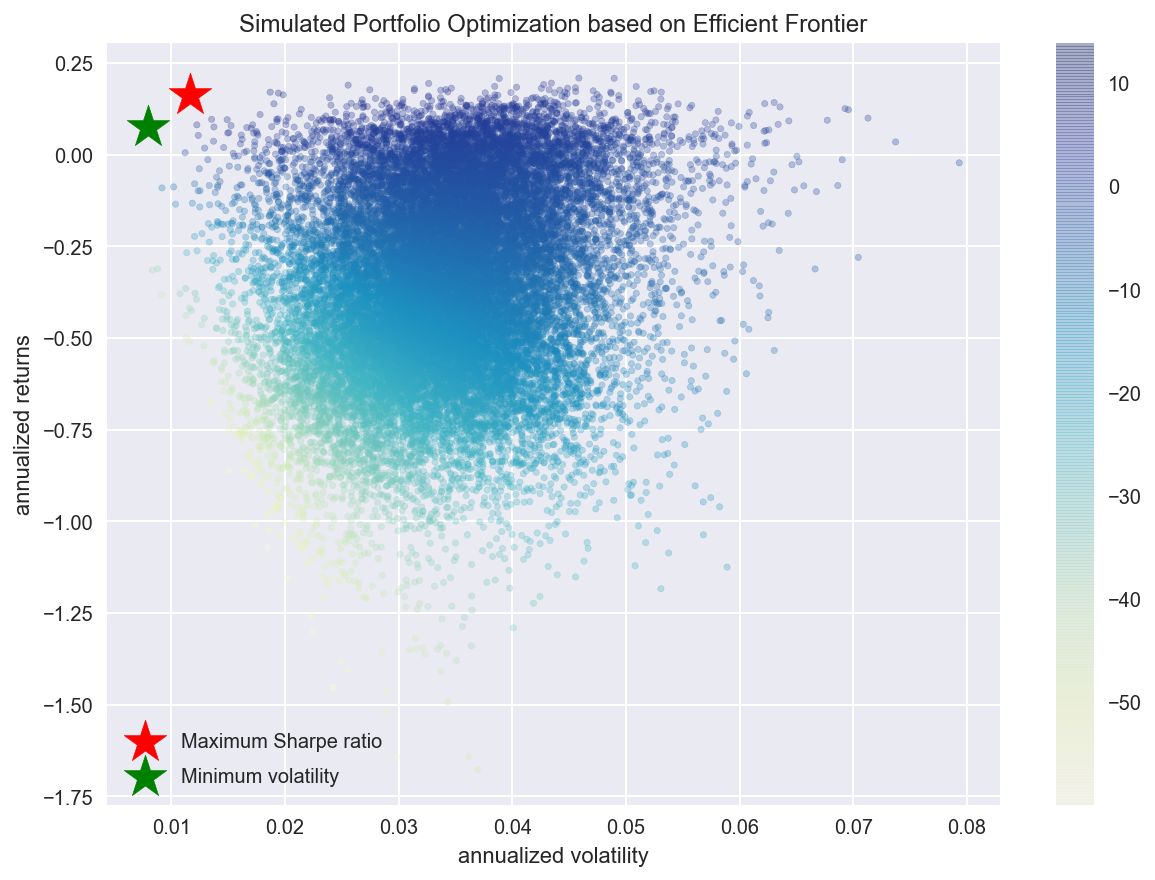

In [18]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)